# Homework 7

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from urllib.parse import unquote
import itertools
from datetime import datetime
import collections

In [210]:
search_df = pd.read_json('search_sample.txt', lines=True)

### Define in utility functions

In [211]:
# This function uses a regular expresion to parse out
# the actual searched value from the url column in the provided row

query_re = re.compile('query=[^&]*')
def get_row_query(row):
    if row['url']:
        match = query_re.search(row['url'])
        if match != None and match[0]:
            return unquote(match[0][6:]).split(' ')
        return "N/A"

In [212]:
# This function returns the time of the entry as an easily manipulated number (example: 2:30 => 14.5)
def get_hour_timestamp(row):
    time = row['timestamp'].hour
    time += round(row['timestamp'].minute/60, 1)
    return time

In [213]:
# This function creates a dictionary {key: value} where the keys are the entries in col_name,
# and the value is the number of times each entry appears
def create_mapping(row, col_name, container):
    
    if col_name == 'query':
        for keyword in row[col_name]:
            if keyword in container:
                container[keyword] += 1
            else:
                container[keyword] = 1
    else:
        if row[col_name] in container:
            container[row[col_name]] += 1
        else:
            container[row[col_name]] = 1

In [214]:
# This function creates two arrays that will be used for the x and y values for a matplotlib chart
def get_chart_values(container):
    x_values = []
    y_values = []
    for time in container:
        x_values.append(container[time])
        y_values.append(time)
    return [x_values, y_values]

In [215]:
# This function creates two arrays that will be used for the x and y values for a matplotlib chart
# Recall that this takes in a list of ordered pairs

def get_ordered_chart_values(ordered_word_counts):
    x_values = []
    y_values = []
    for item in ordered_word_counts:
        x_values.append(item[1])
        y_values.append(item[0])
    return [x_values, y_values]

In [216]:
# This heatmap function will be used to generate the three heatmaps that you need below.

def heatmap(chart_values, title, fig_size):
    np_chart_values = np.array([chart_values[0]])

    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(np_chart_values)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(chart_values[0])))
    ax.set_yticks(np.arange(1))
    # ... and label them with the respective list entries
    ax.set_xticklabels(chart_values[1])
    ax.set_yticklabels(["0 results"])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(1):
        for j in range(len(chart_values[0])):
            text = ax.text(j, i, np_chart_values[i, j],
                           ha="center", va="center", color="w", fontsize=20)

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax.set_title(title, fontsize=20)
    fig.tight_layout()
    plt.show()

### Create query, word_count, and hour columns

In [217]:
search_df['query'] = search_df.apply(lambda row: get_row_query(row), axis=1)
search_df['word_count'] = search_df.apply(lambda row: len(row['query']), axis=1)
search_df['hour'] = search_df.apply(lambda row: get_hour_timestamp(row), axis=1)

### Create new dataframe with only totalresults of 0

In [218]:
df_zero_results = search_df[search_df['totalresults'] == 0]

### Create Keywords dictionary

In [219]:
keyword_map = {}
df_zero_results.apply(lambda row: create_mapping(row, 'query', keyword_map), axis=1)
keyword_map = dict(sorted(keyword_map.items(), key=lambda item: item[1], reverse=True))
top_keywords = dict(itertools.islice(keyword_map.items(), 20))

### Create Timestamp dictionary

In [220]:
hour_map = {}
df_zero_results.sort_values(by=['hour'])
df_zero_results.apply(lambda row: create_mapping(row, 'hour', hour_map), axis=1)

1        None
2        None
5        None
6        None
9        None
         ... 
19993    None
19994    None
19995    None
19996    None
19998    None
Length: 10005, dtype: object

### Create Word Count dictionary

In [221]:
word_count_map = {}
df_zero_results.apply(lambda row: create_mapping(row, 'word_count', word_count_map), axis=1)
ordered_word_counts = sorted(word_count_map.items())

### Create heatmap function

### Part 1

Create a heatmap showing the number of occurences for word counts when the results return are 0

In [222]:
wc_chart_values = get_ordered_chart_values(ordered_word_counts)

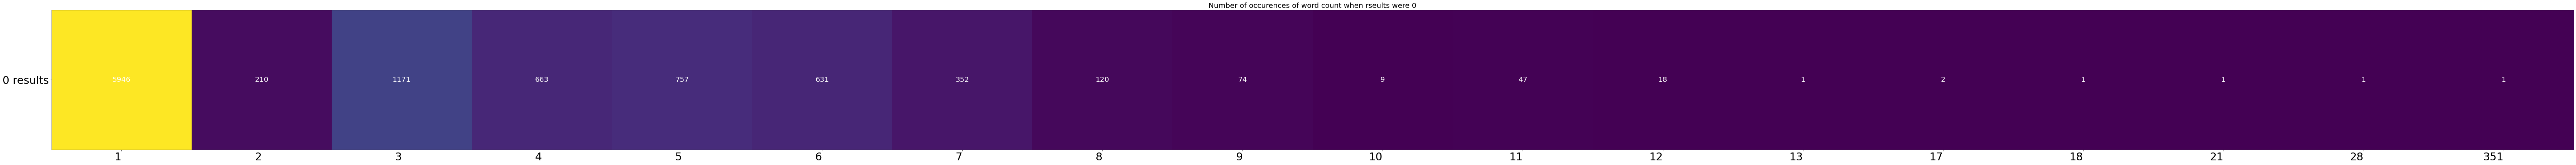

In [223]:
heatmap(wc_chart_values, "Number of occurences of word count when rseults were 0", (100,100))

### Part 2

Repeat the process with the timestamp hour

In [224]:
ts_chart_values = get_chart_values(hour_map)

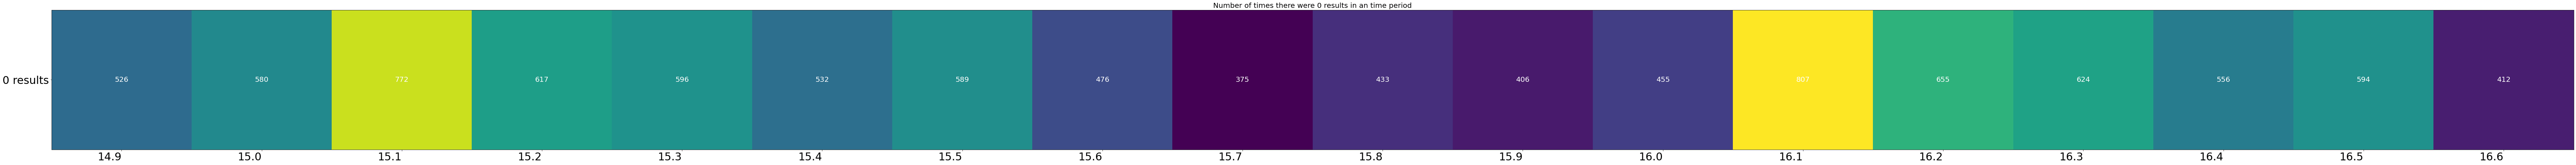

In [225]:
heatmap(ts_chart_values, "Number of times there were 0 results in an time period", (100, 100))

### Part 3

Repeat the process one last time using the top keywords

In [226]:
tk_chart_values = get_chart_values(top_keywords)

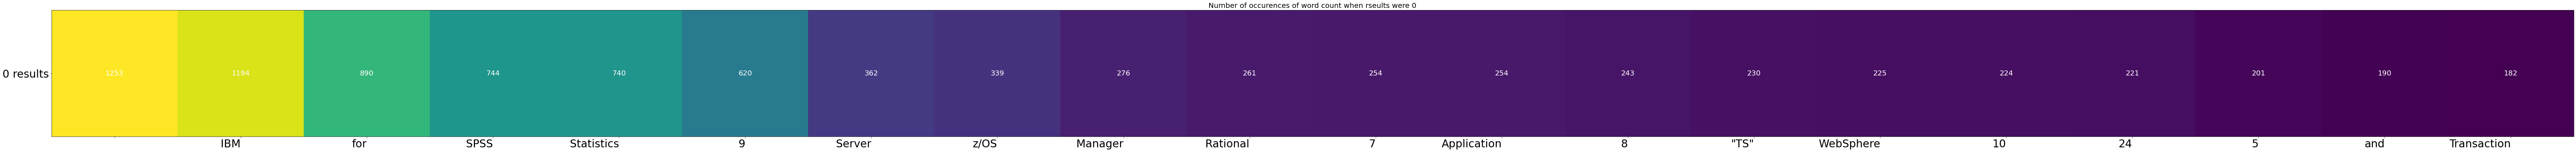

In [227]:
heatmap(tk_chart_values, "Number of occurences of word count when rseults were 0", (100,100))

### Part 4 (Bonus) (Hard)

In this section we're going to create a heatmap that shows how many times a specific word count showed up for a specific scope.

To get the scope we'll have to parse the url string again and add a new column. After that we'll need to create a nested dictionary that will tell us the number of times each word count appears for each scope.

After we have the dictionary we'll need to normalize the data by finding which word counts are missing for each scope and filling that entry with a 0.

Once that is done we'll create a 2D array with the chart values, as well as an array for the x and y labels.

Finally we'll use an updated heatmap function to display the chart.

In [228]:
# This function uses a regular expresion to parse out
# the actual scope value from the url column in the provided row

scope_re = re.compile('scope=[^&]*')
def get_row_scope(row):
    if row['url']:
        match = scope_re.search(row['url'])
        if match != None and match[0]:
            return unquote(match[0][6:])
        return "N/A"

In [229]:
# This function creates a nested dictionary the represents
# how many times each word count shows up in each scope

def create_scope_to_word_count(row, container):
    if row['scope'] in container:
        if row['word_count'] in container[row['scope']]:
            container[row['scope']][row['word_count']] += 1
        else:
            container[row['scope']][row['word_count']] = 1
    else:
        container[row['scope']] = {}

In [230]:
# This function makes sure that each word count is present in each scope
# It does this by comparing each scope dictionary to each other and filling in missing word count entries with 0s
def normalize_data(swc_map):
    swc_map = swc_map
    key_list = list(swc_map.keys())
    for i in key_list:
        for j in key_list:
            for key, value in swc_map[j].items():
                if not key in swc_map[i]:
                    swc_map[i][key] = 0

In [231]:
def sort_objects(swc_map):
    for key in swc_map:
        swc_map[key] = dict(sorted(swc_map[key].items()))

In [232]:
def get_heatmap_chart_values(swc_map):
    x_labels = []
    y_labels = []
    map_values = []
    for key in swc_map:
        y_labels.append(key)
        values = []
        for sub_key in swc_map[key]:
            if not sub_key in x_labels:
                x_labels.append(sub_key)
            values.append(swc_map[key][sub_key])
        map_values.append(values)
        
    return {'x': x_labels, 'y': y_labels, 'values': map_values}

In [233]:
# Uncomment the line below and replace the ? with the correct values
# hint look at the previous calls to the apply function
search_df['scope'] = search_df.apply(lambda row: get_row_scope(row), axis=1)

In [234]:
# Uncomment the line below and replace the ? with the correct dictionary
scope_map = {}
search_df.apply(lambda row: create_mapping(row, 'scope', scope_map), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
19994    None
19995    None
19996    None
19997    None
19998    None
Length: 19999, dtype: object

In [235]:
swc_map = {}
search_df.apply(lambda row: create_scope_to_word_count(row, swc_map), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
19994    None
19995    None
19996    None
19997    None
19998    None
Length: 19999, dtype: object

In [236]:
# Uncomment the line below and replace the ? with the correct dictionary
normalize_data(swc_map)

In [237]:
# Uncomment the line below and replace the ? with the correct dictionary
sort_objects(swc_map)

In [238]:
# Uncomment the line below and replace the ? with the correct dictionary
chart_data = get_heatmap_chart_values(swc_map)

In [239]:
# This heatmap function will be used to generate the three heatmaps that you need below.

def scope_to_keyword_heatmap(chart_data, title, fig_size):
    # Uncomment the line below and replace the ? with the key in chart values that has a 2D array
    np_chart_values = np.array(chart_data['values'])
    
    fig, ax = plt.subplots(figsize=(100, 100))
    im = ax.imshow(np_chart_values)

    # Uncomment the lines below and replace the ? with the correct key value (check the key values in chart_data)
    
    ax.set_xticks(np.arange(len(chart_data['x'])))
    ax.set_yticks(np.arange(len(chart_data['y'])))

    ax.set_xticklabels(chart_data['x'])
    ax.set_yticklabels(chart_data['y'])

    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    for i in range(len(chart_data['y'])):
        for j in range(len(chart_data['x'])):
            text = ax.text(j, i, np_chart_values[i, j],
                           ha="center", va="center", color="w", fontsize=80)

    plt.xticks(fontsize=80)
    plt.yticks(fontsize=80)
    ax.set_title(title, fontsize=100)
    fig.tight_layout()
    plt.show()

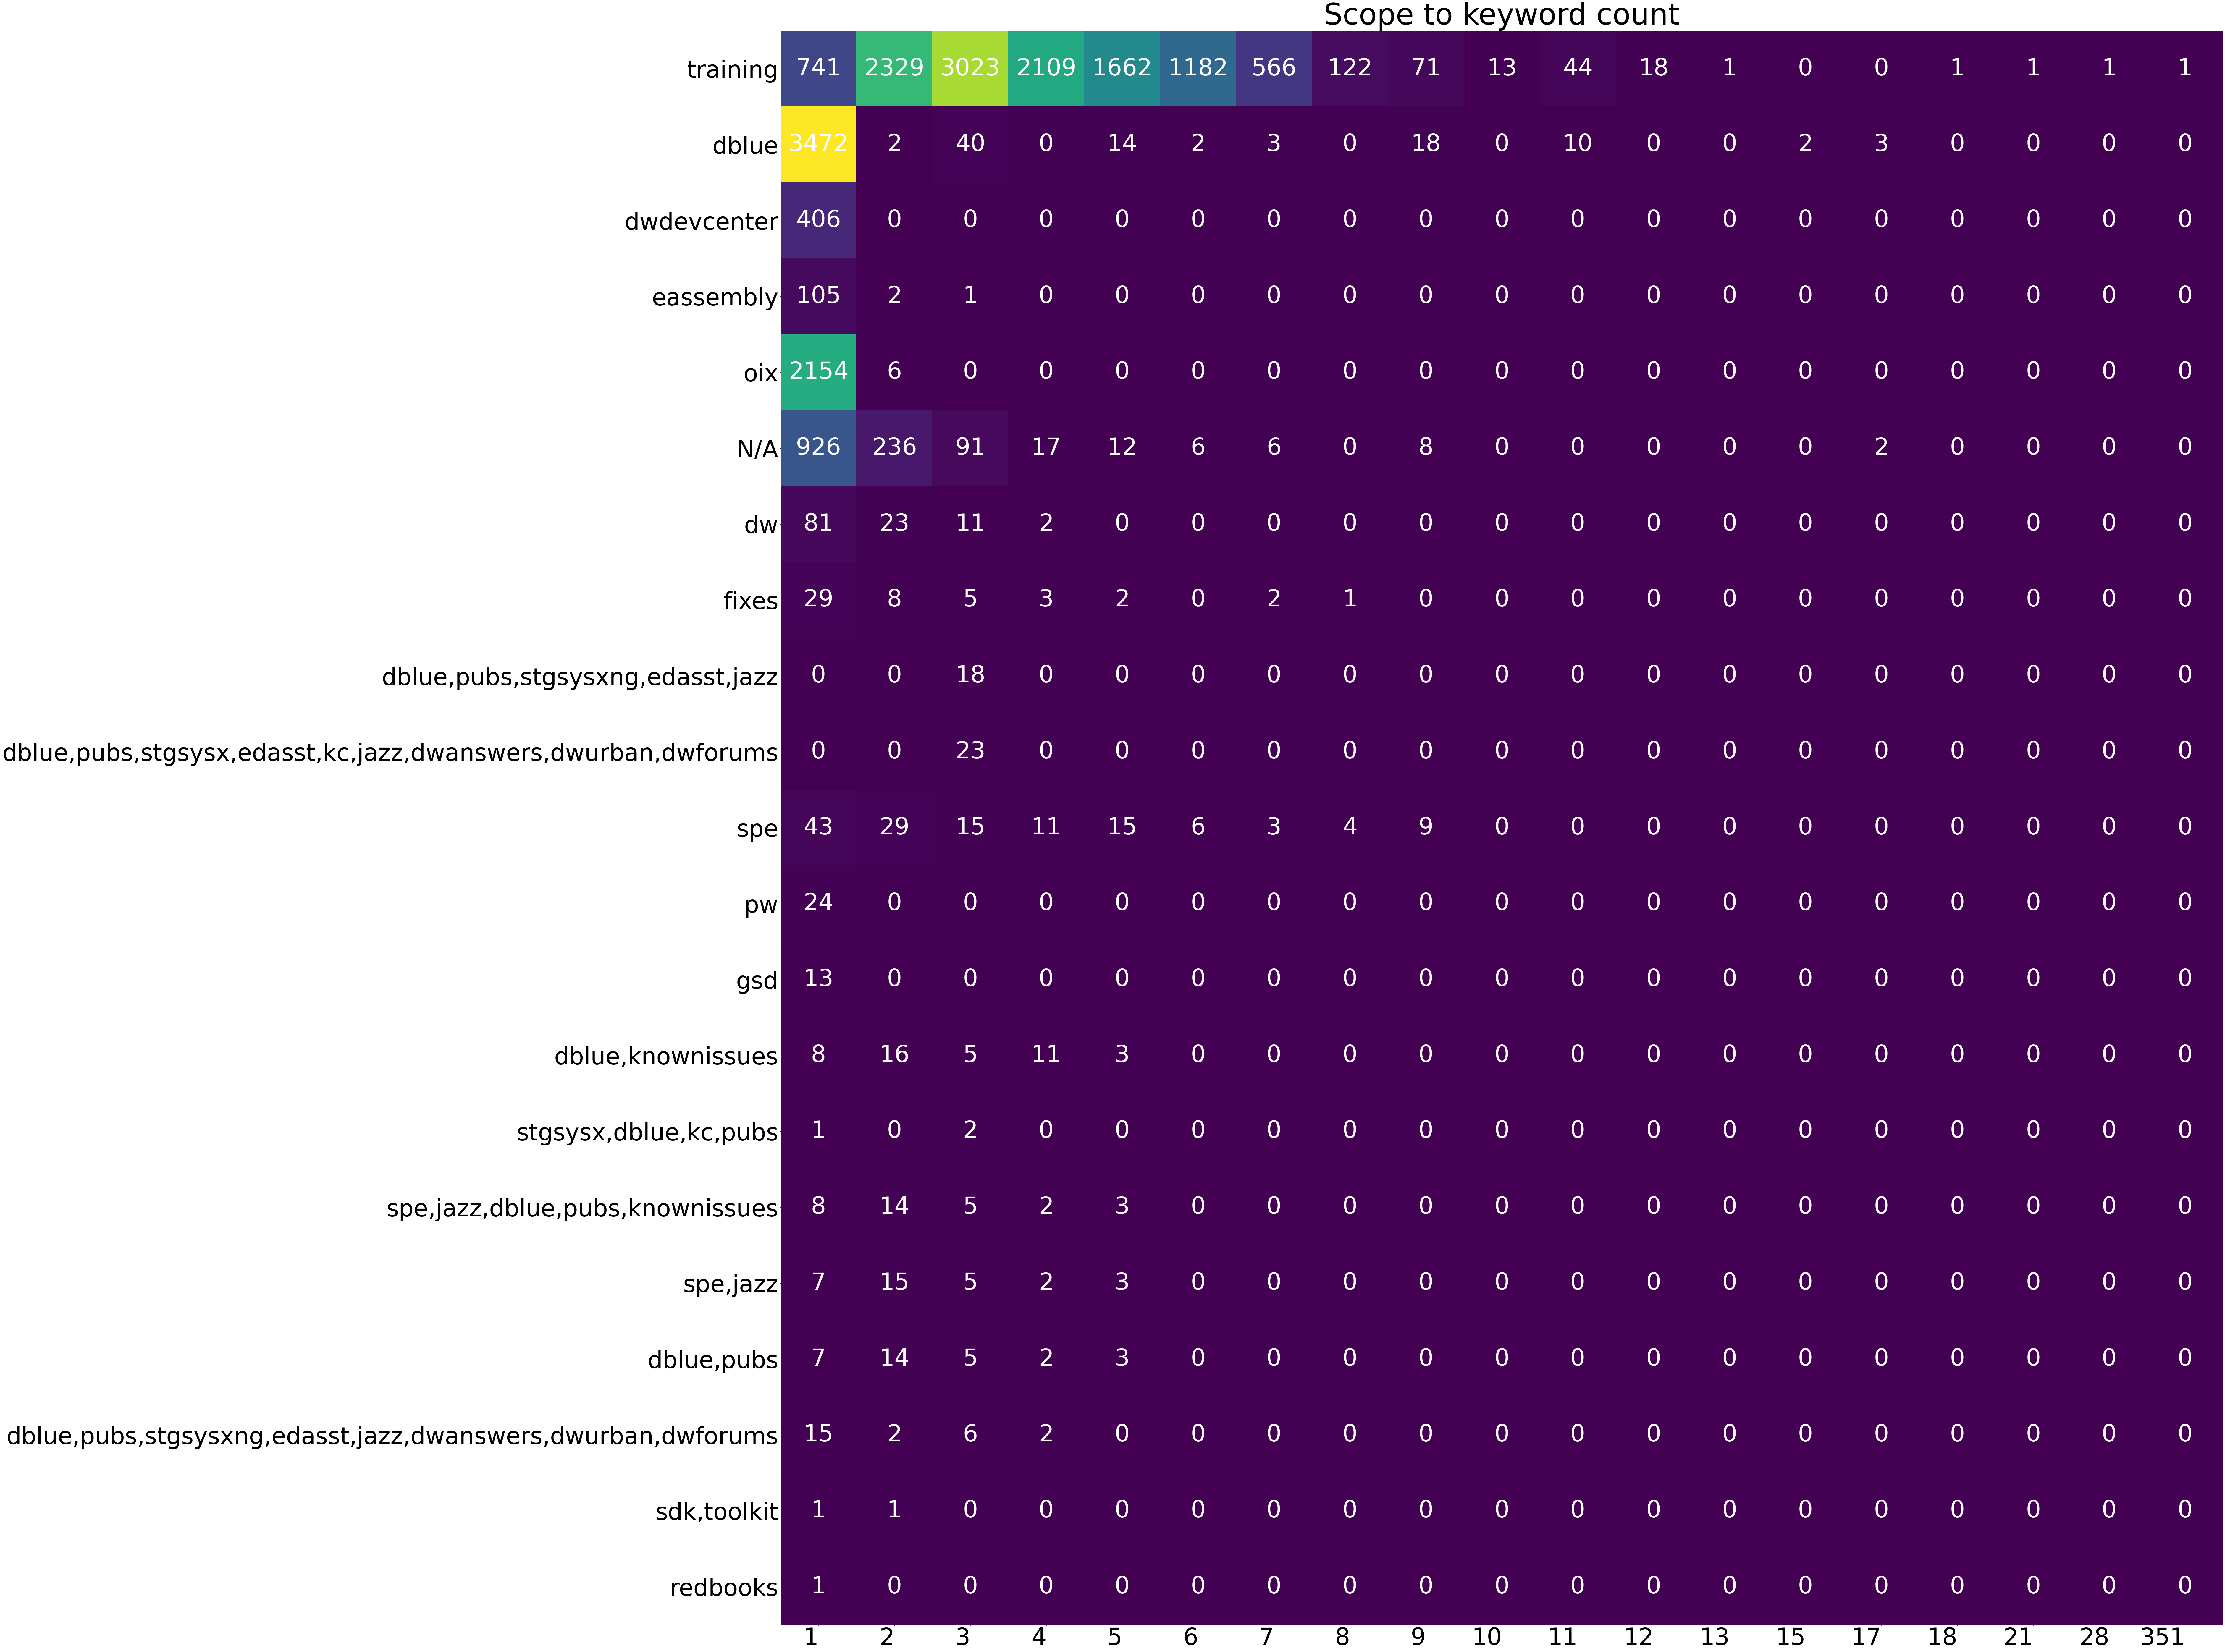

In [240]:
# Uncomment the line below and replace the ? with the correct dictionary
scope_to_keyword_heatmap(chart_data, 'Scope to keyword count', (100,100))